# Starbucks Customers to Offer Prediction

## Importing packages

In [1]:
import pandas as pd
import numpy as np
import json
import data_preprocessing as dp
from sklearn.model_selection import train_test_split
from statistics import mode
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, make_scorer, precision_score
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

from sklearn.tree import export_graphviz, plot_tree

## Reading the datasets

In [2]:
portfolio_df = pd.read_json('../data/portfolio.json', orient='records', lines=True)
profile_df = pd.read_json('../data/profile.json', orient='records', lines=True)
transcript_df = pd.read_json('../data/transcript.json', orient='records', lines=True)

## Feature engineering

### Demographic features

In [3]:
demographic_df = profile_df[['id', 'age', 'gender', 'income']]

### Features related to offer interactions

In [4]:
offers_delivered_df = dp.preprocess_offer_data(transcript_df, portfolio_df)
offers_delivered_df.head()

,person,event,value,time,offer_id,reward,channels,difficulty,duration,offer_type,id,offer_type_event,expiration_time
0,78afa995795e4d85b5d9ceeca43f5fef,offer_received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo_offer_received,7
1,a03223e636434f42ac4c3df47e8bac43,offer_received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount_offer_received,10
2,e2127556f4f64592b11af22de27a7932,offer_received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,discount_offer_received,7
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer_received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,discount_offer_received,10
4,68617ca6246f4fbc85e91a2a49552598,offer_received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo_offer_received,5


### Quantity of offers interactions per type of offer

In [5]:
offer_interactions_df = offers_delivered_df[
    offers_delivered_df.event != 'offer_completed'
].copy()

offer_interactions_df = offer_interactions_df.groupby(['person', 'offer_type_event'])\
    .id.count().reset_index()

offer_interactions_df['offer_type_event'] = offer_interactions_df['offer_type_event']\
    .apply(lambda x: 'qty_' + x)

offer_interactions_df = offer_interactions_df.pivot(
    index='person',
    columns='offer_type_event',
    values='id'
).fillna(0).reset_index()

offer_interactions_df.head()

offer_type_event,person,qty_bogo_offer_received,qty_bogo_offer_viewed,qty_discount_offer_received,qty_discount_offer_viewed,qty_informational_offer_received,qty_informational_offer_viewed
0,0009655768c64bdeb2e877511632db8f,1.0,1.0,2.0,1.0,2.0,2.0
1,00116118485d4dfda04fdbaba9a87b5c,2.0,2.0,0.0,0.0,0.0,0.0
2,0011e0d4e6b944f998e987f904e8c1e5,1.0,1.0,2.0,2.0,2.0,2.0
3,0020c2b971eb4e9188eac86d93036a77,2.0,1.0,2.0,1.0,1.0,1.0
4,0020ccbbb6d84e358d3414a3ff76cffd,2.0,2.0,1.0,1.0,1.0,1.0


In [6]:
def calculate_feature_metrics_per_offer_type(offers_delivered_df, feature):

    group_cols = ['person', 'offer_type']

    grouped_df = offers_delivered_df.groupby(group_cols)\
        .agg({feature: [np.mean, np.min, np.median, np.max]})\
            .round(2).reset_index()
    grouped_df.columns = grouped_df.columns.droplevel()

    grouped_df.columns.values[0] = "person"
    grouped_df.columns.values[1] = "offer_type"

    grouped_df = grouped_df.rename(columns={'amin':'min', 'amax':'max'})

    melted_df = pd.melt(grouped_df, id_vars=group_cols, value_vars=grouped_df.columns[2:])

    melted_df['feature'] = melted_df['variable'] + f'_{feature}_' + melted_df['offer_type']

    pivot_df = melted_df.pivot(
        index='person',
        columns='feature',
        values='value'
    ).fillna(0).reset_index()

    return pivot_df

### Difficulty per offer type

In [7]:
offer_difficulty_df = calculate_feature_metrics_per_offer_type(
    offers_delivered_df, 'difficulty'
)

offer_difficulty_df.head()

feature,person,max_difficulty_bogo,max_difficulty_discount,max_difficulty_informational,mean_difficulty_bogo,mean_difficulty_discount,mean_difficulty_informational,median_difficulty_bogo,median_difficulty_discount,median_difficulty_informational,min_difficulty_bogo,min_difficulty_discount,min_difficulty_informational
0,0009655768c64bdeb2e877511632db8f,5.0,10.0,0.0,5.0,10.0,0.0,5.0,10.0,0.0,5.0,10.0,0.0
1,00116118485d4dfda04fdbaba9a87b5c,5.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0
2,0011e0d4e6b944f998e987f904e8c1e5,5.0,20.0,0.0,5.0,13.5,0.0,5.0,13.5,0.0,5.0,7.0,0.0
3,0020c2b971eb4e9188eac86d93036a77,10.0,10.0,0.0,10.0,10.0,0.0,10.0,10.0,0.0,10.0,10.0,0.0
4,0020ccbbb6d84e358d3414a3ff76cffd,5.0,7.0,0.0,5.0,7.0,0.0,5.0,7.0,0.0,5.0,7.0,0.0


### Offer duration per offer type

In [8]:
offer_duration_df = calculate_feature_metrics_per_offer_type(
    offers_delivered_df, 'duration'
)

offer_duration_df.head()

feature,person,max_duration_bogo,max_duration_discount,max_duration_informational,mean_duration_bogo,mean_duration_discount,mean_duration_informational,median_duration_bogo,median_duration_discount,median_duration_informational,min_duration_bogo,min_duration_discount,min_duration_informational
0,0009655768c64bdeb2e877511632db8f,5.0,10.0,4.0,5.0,8.8,3.5,5.0,10.0,3.5,5.0,7.0,3.0
1,00116118485d4dfda04fdbaba9a87b5c,5.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0
2,0011e0d4e6b944f998e987f904e8c1e5,7.0,10.0,4.0,7.0,8.5,3.5,7.0,8.5,3.5,7.0,7.0,3.0
3,0020c2b971eb4e9188eac86d93036a77,7.0,10.0,3.0,5.5,10.0,3.0,5.0,10.0,3.0,5.0,10.0,3.0
4,0020ccbbb6d84e358d3414a3ff76cffd,7.0,7.0,3.0,6.0,7.0,3.0,6.0,7.0,3.0,5.0,7.0,3.0


### Offer reward per offer type

In [9]:
offer_reward_df = calculate_feature_metrics_per_offer_type(
    offers_delivered_df, 'reward'
)

offer_reward_df.head()

feature,person,max_reward_bogo,max_reward_discount,max_reward_informational,mean_reward_bogo,mean_reward_discount,mean_reward_informational,median_reward_bogo,median_reward_discount,median_reward_informational,min_reward_bogo,min_reward_discount,min_reward_informational
0,0009655768c64bdeb2e877511632db8f,5.0,2.0,0.0,5.0,2.0,0.0,5.0,2.0,0.0,5.0,2.0,0.0
1,00116118485d4dfda04fdbaba9a87b5c,5.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0
2,0011e0d4e6b944f998e987f904e8c1e5,5.0,5.0,0.0,5.0,4.0,0.0,5.0,4.0,0.0,5.0,3.0,0.0
3,0020c2b971eb4e9188eac86d93036a77,10.0,2.0,0.0,10.0,2.0,0.0,10.0,2.0,0.0,10.0,2.0,0.0
4,0020ccbbb6d84e358d3414a3ff76cffd,5.0,3.0,0.0,5.0,3.0,0.0,5.0,3.0,0.0,5.0,3.0,0.0


### When the customer became member

In [10]:
recent_customer_df = profile_df[['id', 'became_member_on']].copy()
recent_customer_df['became_member_year'] = recent_customer_df\
    .became_member_on.astype(str).apply(lambda x: x[:4]).astype(int)

recent_customer_df['became_member_after_2017'] = \
    (recent_customer_df.became_member_year >= 2017)*1

recent_customer_df = recent_customer_df[['id', 'became_member_after_2017']]
recent_customer_df = recent_customer_df.rename(columns={
    'id':'person'
})

recent_customer_df.head()

,person,became_member_after_2017
0,68be06ca386d4c31939f3a4f0e3dd783,1
1,0610b486422d4921ae7d2bf64640c50b,1
2,38fe809add3b4fcf9315a9694bb96ff5,1
3,78afa995795e4d85b5d9ceeca43f5fef,1
4,a03223e636434f42ac4c3df47e8bac43,1


### Target variable of clients to target the offers

In [11]:
transactions_per_offer_type_df = dp.get_customer_transactions_per_offer_type(
    transcript_df, offers_delivered_df
)

In [12]:
grouped_df = transactions_per_offer_type_df.groupby(['person', 'is_offer'])\
    .amount.mean().reset_index()

pivot_df = grouped_df.pivot(
    index='person', 
    columns='is_offer', 
    values='amount'
).fillna(0).round(2).reset_index()

pivot_df = pivot_df.rename(columns={
    0:'avg_amount_without_offer', 1:'avg_amount_with_offer'
})

pivot_df['should_target_offer'] = \
    pivot_df['avg_amount_with_offer'] > pivot_df['avg_amount_without_offer']

pivot_df.tail()

is_offer,person,avg_amount_without_offer,avg_amount_with_offer,should_target_offer
16573,fff3ba4757bd42088c044ca26d73817a,19.09,204.60,True
16574,fff7576017104bcc8677a8d63322b5e1,4.99,0.00,False
16575,fff8957ea8b240a6b5e634b6ee8eafcf,2.43,0.00,False
16576,fffad4f4828548d1b5583907f2e9906b,7.40,0.00,False
16577,ffff82501cea40309d5fdd7edcca4a07,14.89,17.55,True


In [13]:
customers_to_target_df = pivot_df[['person', 'should_target_offer']]

In [14]:
def get_best_offer_type(bogo, discount):
        
    if bogo > discount:
        return 'bogo'

    if discount > bogo:
        return 'discount'

    if discount + bogo == 0:
        return 'none'
        
    return 'either'

In [15]:
offers_completed_df = dp.get_offer_completion_per_customer(offers_delivered_df)

offers_completed_df['best_offer_type'] = offers_completed_df.apply(
    lambda x: get_best_offer_type(x.bogo, x.discount), axis=1
)

offers_completed_df = offers_completed_df[['person', 'best_offer_type']]
offers_completed_df.head()

offer_type,person,best_offer_type
0,0009655768c64bdeb2e877511632db8f,discount
1,00116118485d4dfda04fdbaba9a87b5c,none
2,0011e0d4e6b944f998e987f904e8c1e5,discount
3,0020c2b971eb4e9188eac86d93036a77,discount
4,0020ccbbb6d84e358d3414a3ff76cffd,bogo


## Combining all the features

In [16]:
def join_dataframes(df1, df2, fill_nans=True):
    
    df = df1.merge(
        df2, 
        left_on='id', 
        right_on='person', 
        how='left'
    )

    df = df.drop(columns=['person'], axis=1)

    for col in df2.columns[1:]:
        if fill_nans == True:
            df[col] = df[col].fillna(0)

    return df

In [59]:
df = demographic_df.copy()
df = join_dataframes(df, offer_interactions_df)
df = join_dataframes(df, offer_difficulty_df)
df = join_dataframes(df, offer_duration_df)
df = join_dataframes(df, recent_customer_df)
df = join_dataframes(df, customers_to_target_df)
df = join_dataframes(df, offers_completed_df, fill_nans=False)

In [60]:
df.head()

,id,age,gender,income,qty_bogo_offer_received,qty_bogo_offer_viewed,qty_discount_offer_received,qty_discount_offer_viewed,qty_informational_offer_received,qty_informational_offer_viewed,...,mean_duration_informational,median_duration_bogo,median_duration_discount,median_duration_informational,min_duration_bogo,min_duration_discount,min_duration_informational,became_member_after_2017,should_target_offer,best_offer_type
0,68be06ca386d4c31939f3a4f0e3dd783,118,None,NaN,0.0,0.0,5.0,5.0,0.0,0.0,...,0.00,0.0,10.0,0.0,0.0,7.0,0.0,1,True,discount
1,0610b486422d4921ae7d2bf64640c50b,55,F,112000.0,1.0,0.0,0.0,0.0,1.0,0.0,...,4.00,7.0,0.0,4.0,7.0,0.0,4.0,1,False,bogo
2,38fe809add3b4fcf9315a9694bb96ff5,118,None,NaN,1.0,1.0,0.0,0.0,1.0,1.0,...,3.00,7.0,0.0,3.0,7.0,0.0,3.0,1,False,none
3,78afa995795e4d85b5d9ceeca43f5fef,75,F,100000.0,3.0,3.0,0.0,0.0,1.0,1.0,...,3.00,7.0,0.0,3.0,5.0,0.0,3.0,1,False,bogo
4,a03223e636434f42ac4c3df47e8bac43,118,None,NaN,0.0,0.0,3.0,2.0,2.0,1.0,...,3.67,0.0,10.0,4.0,0.0,10.0,3.0,1,False,none


In [61]:
df['best_offer_type'] = df['best_offer_type']\
    .fillna(df['should_target_offer'].map(lambda x: 'either' if x is True else 'none'))

In [62]:
df['should_target_offer'] = df['best_offer_type'].apply(
    lambda x: 'target' if x != 'none' else 'not_target'
)

## Splitting data in training, validation and test subsets

In [63]:
X = df.drop(columns=['id', 'should_target_offer', 'best_offer_type'], axis=1)
y = df.should_target_offer

In [64]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size= 0.1, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size= 0.25, random_state=42
)

X_train.shape, X_val.shape, X_test.shape

((11475, 34), (3825, 34), (1700, 34))

## Dealing with missing data

In [65]:
missing_values_dict = {
    'gender': mode(X_train['gender']),
    'income': X_train.income.median()
}

In [66]:
def fill_missing_data(df, missing_values_dict):

    new_df = df.copy()

    new_df['gender'] = new_df['gender'].fillna(missing_values_dict['gender'])
    new_df['income'] = new_df['income'].fillna(missing_values_dict['income'])

    return new_df

In [67]:
X_train = fill_missing_data(X_train, missing_values_dict)
X_val = fill_missing_data(X_val, missing_values_dict)
X_test = fill_missing_data(X_test, missing_values_dict)

## Handling the categorical data

### Using One Hot Encoding on categorical data

In [68]:
def apply_one_hot_encoding(df, feature, encoder):

    one_hot_enc_df = encoder.transform(df[feature].values.reshape(-1,1)).toarray()
    
    enc_df = pd.DataFrame(
        one_hot_enc_df, 
        columns = encoder.categories_[0][1:].tolist()
    )
    
    new_cols_names = {col: feature + '_' + col for col in enc_df.columns}
    enc_df = enc_df.rename(columns = new_cols_names)

    final_df = pd.concat([df.reset_index(), enc_df], axis = 1)\
        .drop(columns = ['index', feature])
    
    return final_df

In [69]:
def feature_one_hot_encoding(X_train, X_val, X_test, feature):
    
    encoder = OneHotEncoder(drop='first').fit(X_train[feature].values.reshape(-1,1))

    X_train = apply_one_hot_encoding(X_train, feature, encoder)
    X_val = apply_one_hot_encoding(X_val, feature, encoder)
    X_test = apply_one_hot_encoding(X_test, feature, encoder)

    return X_train, X_val, X_test

In [70]:
X_train, X_val, X_test = feature_one_hot_encoding(
    X_train, X_val, X_test, 'gender'
)

### Using Label Encoding on the target variable

In [71]:
le = LabelEncoder()
le.fit(y_train)

y_train = le.transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)

In [72]:
label_mapping_df = pd.DataFrame({
    'class': le.classes_ , 'value': le.transform(le.classes_)
})

label_mapping_df

,class,value
0,not_target,0
1,target,1


## Building the models

### Auxiliar functions

In [75]:
def plot_balanced_accuracy_heatmap(y, y_pred, classes):

  """Function that calculate the precision and balanced accuracy
  of a given prediction and true values. It also plots a relative
  confusion matrix to evaluate the classification.

  Args:
      y (numpy array): true target values
      y_pred (numpy array): predicted target values
      classes (list): list of possible classes to predict
  """
  
  print(f'Precision:{precision_score(y, y_pred)}')
  print(f'Balanced accuracy:{balanced_accuracy_score(y, y_pred)}\n')

  cm = confusion_matrix(y, y_pred, normalize='true').round(2)
  df = pd.DataFrame(data=cm,columns=classes, index=classes)

  plt.figure(figsize=(8,8))
  sns.heatmap(
      df, 
      cmap='Blues', 
      annot=True,
  ).set(xlabel='Predicted', ylabel='Expected')
  plt.show()

### Creating a baseline result using Decision Tree

In [73]:
dt_classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 42)
dt_classifier.fit(X_train, y_train)

baseline_train_pred = dt_classifier.predict(X_train)
baseline_val_pred = dt_classifier.predict(X_val)

Precision:0.8381053375751149
Balanced accuracy:0.6628561201672327



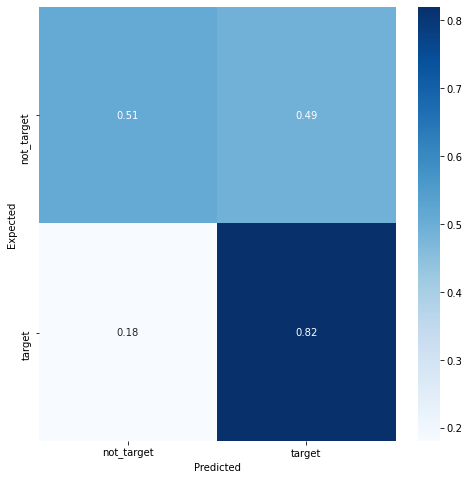

In [76]:
plot_balanced_accuracy_heatmap(y_val, baseline_val_pred, le.classes_)

### Using Random Forest

In [34]:
pred_dicts = []
depths = np.arange(1, 50)

for depth in depths:

    rf_classificer = RandomForestClassifier(
        max_depth=depth, 
        criterion='entropy', 
        random_state=42
    )
    
    rf_classificer.fit(X_train, y_train)

    train_pred = rf_classificer.predict(X_train)
    val_pred = rf_classificer.predict(X_val)

    prediction = {
        'depth': depth,
        'train_precision': precision_score(y_train, train_pred),
        'val_precision': precision_score(y_val, val_pred)
    }

    pred_dicts.append(prediction)

rf_df = pd.DataFrame(pred_dicts)

<AxesSubplot:xlabel='depth'>

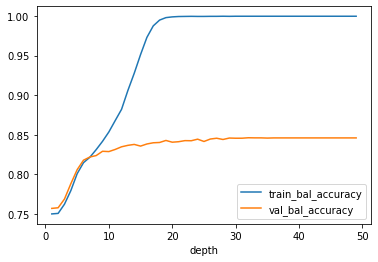

In [35]:
rf_df.set_index('depth').plot()

In [77]:
best_depth = rf_df[
    rf_df.val_bal_accuracy == rf_df.val_bal_accuracy.max()
].depth.values[0]

best_depth

32

In [78]:
best_rf_classificer = RandomForestClassifier(
    max_depth=best_depth, 
    criterion='entropy', 
    random_state=42
)

best_rf_classificer.fit(X_train, y_train)

best_rf_val_pred = best_rf_classificer.predict(X_val)

Precision:0.8463223787167449
Balanced accuracy:0.7025881807206703



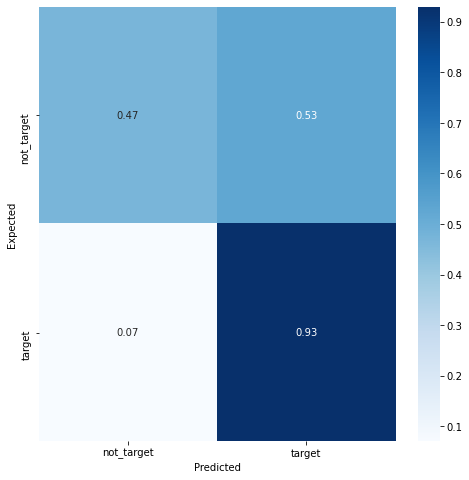

In [79]:
plot_balanced_accuracy_heatmap(y_val, best_rf_val_pred, le.classes_)

### Using SVC

In [39]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [40]:
C_range = np.logspace(-2, 2, 5)
kernels = ['linear', 'rbf', 'sigmoid']
param_grid = dict(C=C_range, kernel=kernels)
print('param_grid:', param_grid)

param_grid: {'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]), 'kernel': ['linear', 'rbf', 'sigmoid']}


In [41]:
svc_model = SVC(random_state = 42)
bas = make_scorer(balanced_accuracy_score, greater_is_better=True)
grid = GridSearchCV(svc_model, param_grid, cv=5, scoring=bas,verbose=3)
grid.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END .............C=0.01, kernel=linear;, score=0.648 total time=   4.9s
[CV 2/5] END .............C=0.01, kernel=linear;, score=0.654 total time=   4.6s
[CV 3/5] END .............C=0.01, kernel=linear;, score=0.650 total time=   4.2s
[CV 4/5] END .............C=0.01, kernel=linear;, score=0.651 total time=   4.1s
[CV 5/5] END .............C=0.01, kernel=linear;, score=0.639 total time=   4.2s
[CV 1/5] END ................C=0.01, kernel=rbf;, score=0.500 total time=   7.0s
[CV 2/5] END ................C=0.01, kernel=rbf;, score=0.500 total time=   7.0s
[CV 3/5] END ................C=0.01, kernel=rbf;, score=0.500 total time=   6.9s
[CV 4/5] END ................C=0.01, kernel=rbf;, score=0.500 total time=   6.8s
[CV 5/5] END ................C=0.01, kernel=rbf;, score=0.500 total time=   6.9s
[CV 1/5] END ............C=0.01, kernel=sigmoid;, score=0.505 total time=   6.8s
[CV 2/5] END ............C=0.01, kernel=sigmoid;

GridSearchCV(cv=5, estimator=SVC(random_state=42),
             param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'kernel': ['linear', 'rbf', 'sigmoid']},
             scoring=make_scorer(balanced_accuracy_score), verbose=3)

In [80]:
best_svc = grid.best_estimator_
y_pred_train = best_svc.predict(X_train_scaled)
y_pred_val = best_svc.predict(X_val_scaled)

Precision:0.845061533606816
Balanced accuracy:0.6980992304444272



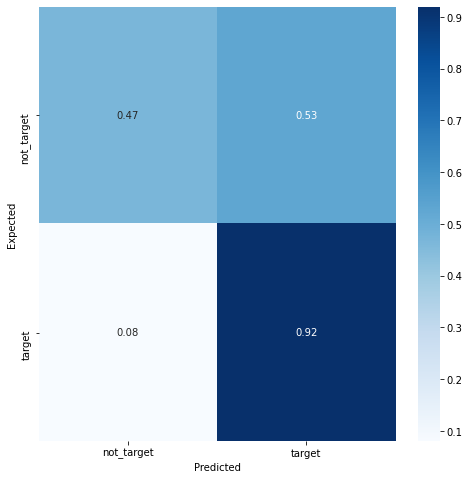

In [82]:
plot_balanced_accuracy_heatmap(y_val, y_pred_val,  le.classes_)

## Applying the best model on the Test set

In [83]:
best_rf_test_pred = best_rf_classificer.predict(X_test)

Precision:0.8418079096045198
Balanced accuracy:0.6929211651302394



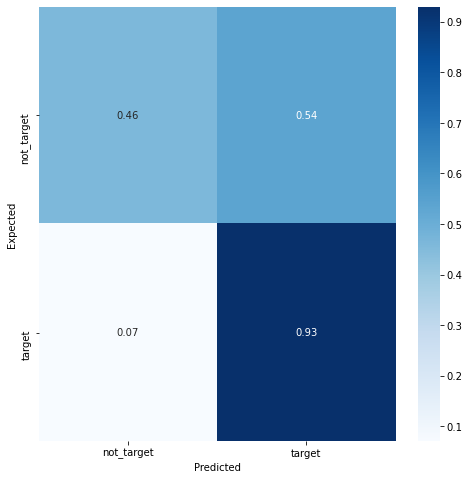

In [84]:
plot_balanced_accuracy_heatmap(y_test, best_rf_test_pred,  le.classes_)